# Rag From Scratch: Overview

These notebooks walk through the process of building RAG app(s) from scratch.

They will build towards a broader understanding of the RAG langscape, as shown here:

Docs:

* https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever

### Index

In [1]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. This approach allows agents to better plan and execute tasks by transforming big tasks into more manageable ones. Task decomposition can be achieved through various methods, such as using prompting techniques, task-specific instructions, or human inputs.'

![Screenshot from 2024-06-24 20-16-18.png](<attachment:Screenshot from 2024-06-24 20-16-18.png>)
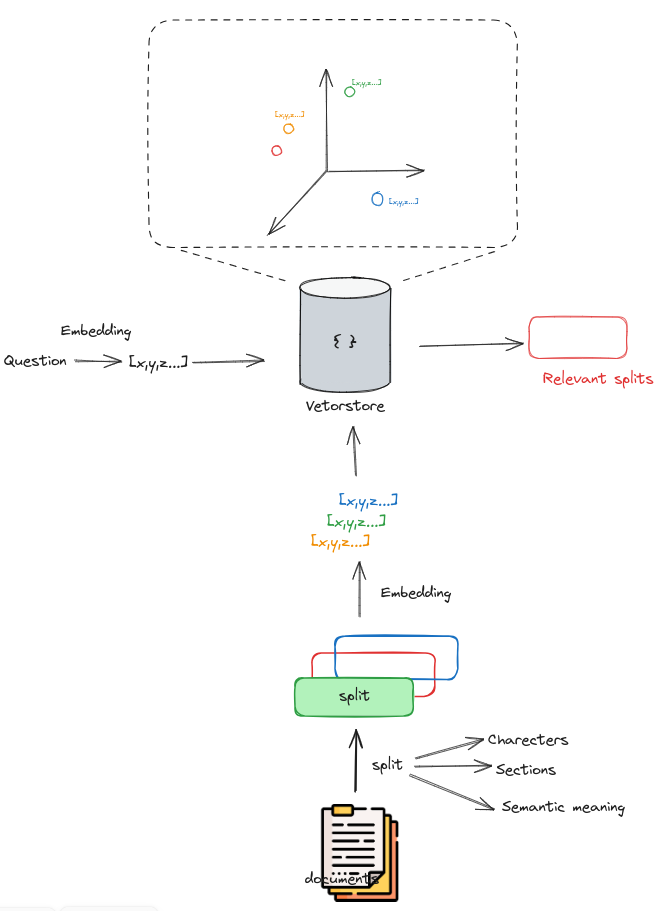

In [2]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

[Count tokens](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb) considering [~4 char / token](https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them)

In [3]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

8

[Text embedding models](https://python.langchain.com/docs/integrations/text_embedding/openai)

In [4]:
from langchain_openai import OpenAIEmbeddings
embd = OpenAIEmbeddings()
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
len(query_result)

1536

[Cosine similarity](https://platform.openai.com/docs/guides/embeddings/frequently-asked-questions) is reccomended (1 indicates identical) for OpenAI embeddings.

In [5]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.880704473084765


[Document Loaders](https://python.langchain.com/docs/integrations/document_loaders/)

In [6]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

In [7]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

In [8]:
# Index
# Vector Stores

from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

# Part3. Retrieval

In [9]:
# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())


retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [10]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")

/home/minyoungxi/.local/share/virtualenvs/LLM_Langchain_APP-7aD6jX0r/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [11]:
len(docs)

1

# Generation

![Screenshot from 2024-06-24 21-08-54.png](<attachment:Screenshot from 2024-06-24 21-08-54.png>)
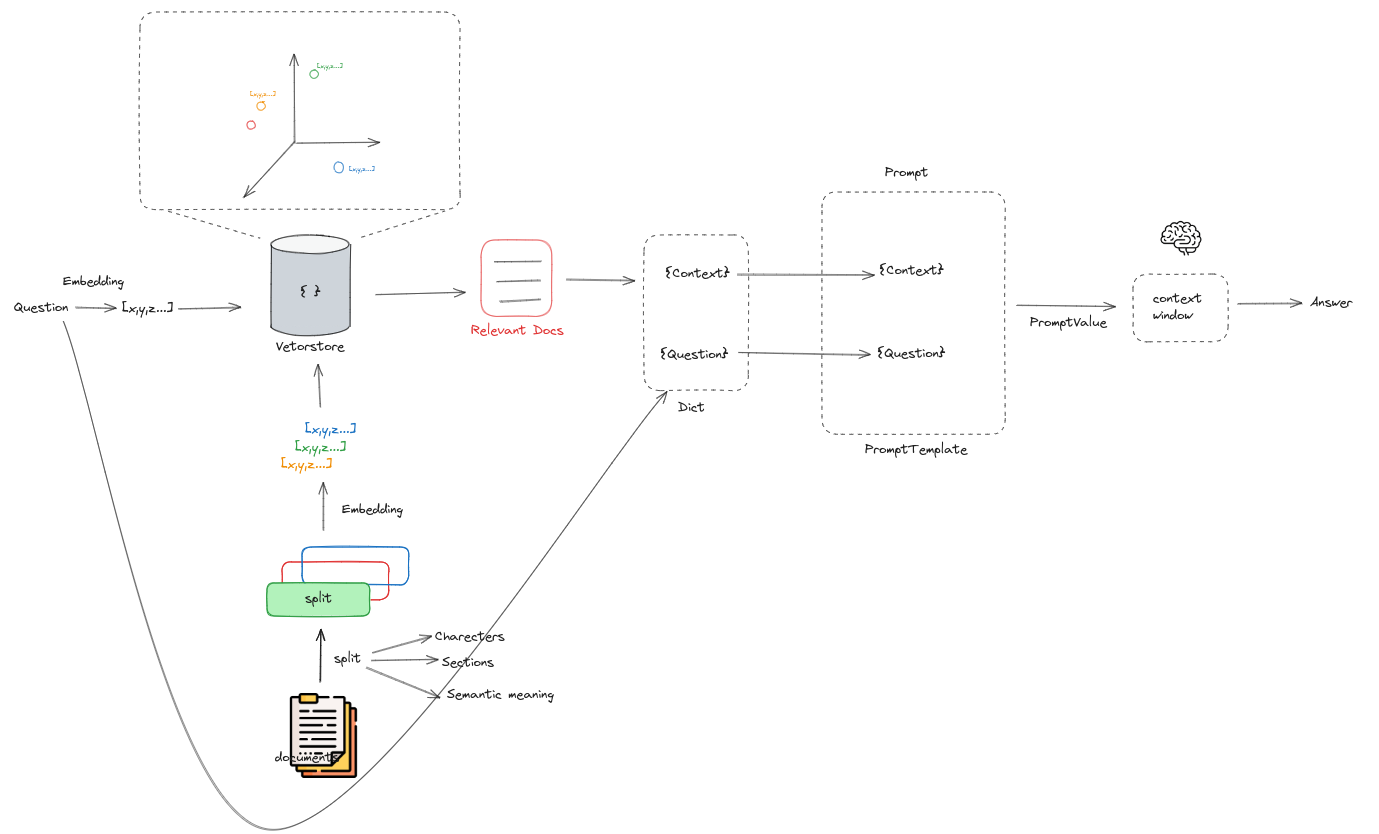

In [12]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'))])

In [13]:
# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [14]:
# Chain
chain = prompt | llm

In [15]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

AIMessage(content='Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps, making them more manageable for an autonomous agent system. It can be achieved through prompting techniques like Chain of Thought and Tree of Thoughts, as well as task-specific instructions or human inputs.', response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 331, 'total_tokens': 385}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-cd629914-41bc-4bdb-abf0-8cf536d81a8e-0', usage_metadata={'input_tokens': 331, 'output_tokens': 54, 'total_tokens': 385})

In [16]:
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")

In [17]:
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [18]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is the process of breaking down a complex task into smaller and simpler steps in order to make it more manageable for an autonomous agent system. This can be achieved through techniques such as Chain of Thought and Tree of Thoughts, which prompt the model to think step by step and explore multiple reasoning possibilities at each step. Task decomposition can also be done through simple prompting, task-specific instructions, or with human inputs.'

# Multi query

![Screenshot from 2024-06-28 15-58-43.png](<attachment:Screenshot from 2024-06-28 15-58-43.png>)
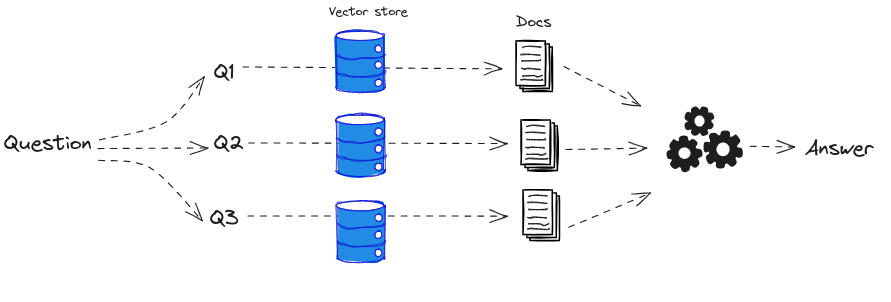

In [19]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [20]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

/home/minyoungxi/.local/share/virtualenvs/LLM_Langchain_APP-7aD6jX0r/lib/python3.10/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


1

In [21]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down complex tasks into smaller and simpler steps using techniques such as Chain of Thought (CoT) and Tree of Thoughts. This allows the agent to utilize more test-time computation and enhance its performance on complex tasks by transforming big tasks into multiple manageable tasks. Task decomposition can be achieved through simple prompting, task-specific instructions, or with human inputs.'